In [54]:
import torch
import numpy as np

def cosin_metric(x1, x2):
    return torch.dot(x1, x2) / (torch.linalg.norm(x1) * torch.linalg.norm(x2))

def cosin_metric(x1, x2):
    u=torch.einsum ('id, jd -> ij', x1, x2)
    d1=torch.linalg.norm(x1,dim=1)
    d2=torch.linalg.norm(x2,dim=1)
    d=torch.einsum ('i, j -> ij', d1, d2)
    return u/d

batch=2
dim=4

feature_a=[]
for i in range(4):
    feature_a.append((torch.rand(size=[batch,dim]),torch.LongTensor([i]*2)))

feature_b=[]
for i in range(3):
    feature_b.append((torch.rand(size=[batch,dim]),torch.LongTensor([i]*2)))

x_a=torch.cat([t[0] for t in feature_a])
y_a=torch.cat([t[1] for t in feature_a])

x_b=torch.cat([t[0] for t in feature_b])
y_b=torch.cat([t[1] for t in feature_b])

cosin=cosin_metric2(x_a,x_b)
print(cosin)
cosin_max,idx=torch.max(cosin,dim=1)
print(cosin_max,idx)
pred=y_b[idx]
print(pred)

tensor([[0.7607, 0.9739, 0.9510, 0.9729, 0.9718, 0.7884],
        [0.8112, 0.8677, 0.6319, 0.7814, 0.8104, 0.9583],
        [0.9323, 0.8429, 0.8138, 0.7994, 0.9423, 0.8388],
        [0.8825, 0.9586, 0.8460, 0.8977, 0.9774, 0.9044],
        [0.9421, 0.9210, 0.8408, 0.8902, 0.9539, 0.9493],
        [0.6523, 0.8675, 0.9594, 0.9122, 0.9035, 0.6049],
        [0.4414, 0.7910, 0.6894, 0.6655, 0.8149, 0.4133],
        [0.7316, 0.9037, 0.9330, 0.8911, 0.9620, 0.6646]])
tensor([0.9739, 0.9583, 0.9423, 0.9774, 0.9539, 0.9594, 0.8149, 0.9620]) tensor([1, 5, 4, 4, 4, 2, 4, 4])
tensor([0, 2, 2, 2, 2, 1, 2, 2])


# kfold

In [5]:
import numpy as np
from sklearn.model_selection import KFold
X = [1,2,3,4,5]

kf=KFold(n_splits=5, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print([X[i] for i in train_index ])

[2, 3, 4, 5]
[1, 3, 4, 5]
[1, 2, 4, 5]
[1, 2, 3, 5]
[1, 2, 3, 4]


# crop coco instance (imagenet format)

In [2]:
from pycocotools.coco import COCO
import cv2,os
import numpy as np
from tqdm import tqdm

input_image_path=r"D:\yc\data\hix\rt\all"
input_json_path=fr"D:\yc\data\hix\rt/val.json"
output_path=f"{input_image_path}_instance"
bleed=(2.0,2.0)
with_mask=False

data=COCO(input_json_path)

instances=list(data.anns.values())
images=data.imgs
classes=data.cats

classes_name=[t["name"] for t in classes.values()]
for c in classes_name:
    os.makedirs(f"{output_path}/{c}",exist_ok=True)

error=0
for ins in tqdm(instances):
    try:
        c=classes[ins["category_id"]]["name"]
        image=images[ins["image_id"]]["file_name"]#.replace(".jpg",".png")
        name=ins["id"]
        
        bbox=ins["bbox"]
        img=cv2.imread(f"{input_image_path}/{image}")
        
        if with_mask:
            mask=data.annToMask(ins)
            img=img*mask[:,:,np.newaxis]
        
        bleed_x=bbox[2]*(bleed[0]-1.0)/2.0
        bleed_y=bbox[3]*(bleed[1]-1.0)/2.0
        
        x1=int(bbox[0])
        x2=int(bbox[0]+bbox[2])
        y1=int(bbox[1])
        y2=int(bbox[1]+bbox[3])
        
        y1=max(0,y1)
        x1=max(0,x1)
        y2=min(img.shape[0],y2)
        x2=min(img.shape[1],x2)
        
        crop=img[y1:y2,x1:x2,:]
        
        cv2.imwrite(f"{output_path}/{c}/{name}.png",crop)
    except:
        error+=1
        
print(f"error:{error}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 163/163 [00:01<00:00, 146.48it/s]

error:0


# rename in project data

In [11]:
import os,re

input_path="D:/yc/data/all/side"

os.chdir(input_path)

for x in os.listdir():
    os.rename(x,"side_"+x)

# feature 抽取

In [25]:
import os,shutil,re,random
import numpy as np
import torch.optim as optim

from tqdm import tqdm
from colorama import Fore

from config import Config
from data import *
from model import *

opt = Config()

opt.valid_frac=0.0
datasets,_,_=build_split(opt)
metrics={"precision":[]}
device = "cuda"
valid_set,_=datasets[0]
# _,valid_set=datasets[0]

valid_loader = DataloaderBase(dataset=valid_set,opt=opt)

# model=torch.load(f"{opt.save}/best.pt")
model=MMPretrainByol(model=r'D:\yc\mmpretrain\benchmark\byol.py',pretrained='D:/save/dm_byol/epoch_100.pth')

model.to(device)
model.eval()

data=[]
for x,y,_ in tqdm(valid_loader,total=len(valid_loader)):
    x= x.to(device)
    feature = model(x)

    data.append(np.hstack((np.array(y.unsqueeze(-1).numpy()),feature.detach().cpu().numpy())))

data=np.vstack(data)
np.save(f"{opt.save}/feature_byol.npy",data)

['HS', 'YS-Dot', 'YS-DTZ-C', 'YS-DTZ-L', 'YS-Line', 'YSQX']


d:\yc\python\python38\lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Loads checkpoint by local backend from path: D:/save/dm_byol/epoch_100.pth


100%|██████████| 64/64 [00:07<00:00,  8.27it/s]


# tsne / umap

['HS', 'YS-Dot', 'YS-DTZ-C', 'YS-DTZ-L', 'YS-Line', 'YSQX']
(1022, 321)


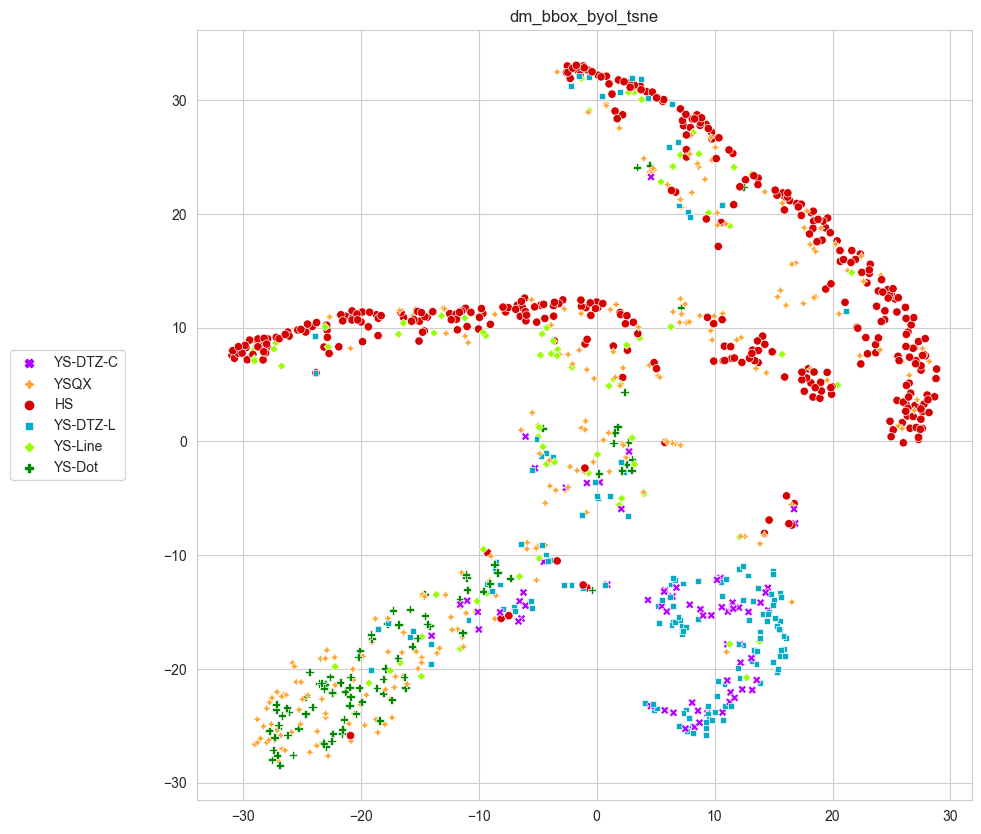

In [26]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
import colorcet as cc

from config import Config
cfg=Config()

classes = os.listdir(cfg.data_root)
print(classes)

x=np.load(f"{cfg.save}/feature_byol.npy",allow_pickle=True)
print(x.shape)
c=x[:,0].astype(int)
# k=np.isin(c,[0,1,2,3,4,5,6,7])
# c=c[k]
c=[classes[i] for i in list(c)]
# feature=x[k,1:]
feature=x[:,1:]

key="dm_bbox_byol"

# color_palette = sns.color_palette("tab10",n_colors=len(classes))
color_palette = sns.color_palette(cc.glasbey_light,n_colors=len(classes))
color_palette = {x:y for x,y in zip(classes,color_palette)}
domains=[t.split("_")[0] for t in c]
style_order=sorted(list(set(domains)))

key1=f"{key}_tsne"
np.random.seed(11)
emb = TSNE(n_components=2,init="random",perplexity=30,n_iter=500).fit_transform(feature)
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,
                style=domains,
                style_order=style_order,
                palette=color_palette,alpha=1.0)
g.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5), ncol=1)
plt.title(f"{key1}")
plt.savefig(f"{cfg.save}/{key1}.png",dpi=300,bbox_inches="tight")
# plt.show()

# key2=f"{key}_UMAP"
# emb=umap.UMAP(n_neighbors=15,min_dist=0.1,random_state=14).fit_transform(feature)
# plt.figure(figsize=(10,10))
# sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,
#                 style=domains,
#                 style_order=style_order,
#                 palette=color_palette,alpha=1.0)
# plt.title(f"{key2}")
# plt.savefig(f"{cfg.save}/{key2}.png",dpi=300)

# 特征图可视化

In [ ]:
import os,shutil,re,random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

from config import Config
from data import *
from model import *

def merge(imgs, ncol=28):
    nrow = math.ceil(len(imgs) / ncol)
    imgs += [np.zeros(imgs[0].shape, dtype=np.uint8) for _ in range(nrow * ncol - len(imgs))]

    rows = []
    for i in range(nrow):
        rows.append(np.concatenate(imgs[i * ncol:(i + 1) * ncol], axis=1))

    img_concat = np.concatenate(rows, axis=0)
    
    return img_concat

features = []
def hook(module, input, output): 
    features.append(output.clone().detach().cpu().numpy())

cfg = Config()
classes = os.listdir(cfg.data_root)

cfg.valid_frac=0.0
cfg.return_meta=True

datasets,_,_=build_split(cfg)
device = "cuda"
valid_set,_=datasets[0]

valid_loader = DataloaderBase(dataset=valid_set,opt=cfg)

model=torch.load(f"{cfg.save}/best.pt")
model.to(device)
model.eval()

handle = model.backbone.norm_pre.register_forward_hook(hook)

labels=[]
file_names=[]
for x,y,sample in tqdm(valid_loader,total=len(valid_loader)):
    x= x.to(device)
    _ = model(x)
    labels.append(y.unsqueeze(-1).numpy())
    file_names+=[t["file"] for t in sample]

handle.remove()

features=np.vstack(features)
labels=np.vstack(labels)
# np.save(f"{cfg.save}/feature_map.npy",data)
# np.save(f"{cfg.save}/label.npy",label)

choose_labels=[1, 0]
choose_nums=[2,2]
labels=np.squeeze(labels,axis=1)
k=np.zeros(labels.shape[0],dtype=bool)

random.seed(12)
choose_index={}
for l,n in zip(choose_labels,choose_nums):
    t=(labels==l)
    p=np.where(t)
    q=random.sample(list(p[0]),n)
    choose_index[l]=q

feature_maps={x:features[choose_index[x],...] for x in choose_index}
file_names={x:file_names[choose_index[x]] for x in choose_index}

j=0
for c in choose_index.keys():
    feature_map=feature_maps[c]
    file_name=file_names[c]

    for m,file in zip(feature_map,file_name):
        imgs=[m[i] for i in range(m.shape[0])]
        img_cat=merge(imgs)
        
        img_raw=cv2.imread(file)
        
        _, axes = plt.subplots(1, 2, figsize=(24, 24))
        ax=axes[0]
        ax.set_title(f"{classes[c]}")
        ax.imshow(img_cat)
        ax.set_xticks(np.arange(-0.5,img_cat.shape[1]-0.5,imgs[0].shape[1]),color=(0,0,0,0))
        ax.set_yticks(np.arange(-0.5,img_cat.shape[0]-0.5,imgs[0].shape[0]),color=(0,0,0,0))
        ax.grid(True)
        
        j+=1
        plt.savefig(f"{cfg.save}/{j}.png",dpi=300,bbox_inches="tight")

# feature 抽取 zeroshot

In [2]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:33210"
os.environ["https_proxy"] = "http://127.0.0.1:33210"

from PIL import Image

import torchvision.transforms as T
import torch
import random
import numpy as np
from model import VGG,ConvNext,HF

from tqdm import tqdm

input_path=r"D:\yc\work\xd\hs\val"
classes=os.listdir(input_path)

random.seed(12)
images=[]
for c in classes:
    imgs=os.listdir(f"{input_path}/{c}")
    images+=[(f"{input_path}/{c}/{t}",classes.index(c)) for t in imgs]
    
model=ConvNext().cuda()

transform = T.Compose(
    [
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

data=[]
for image,c in tqdm(images):
    x = torch.stack([transform(Image.open(image))]).to("cuda")
    feature = model(x)
    # print(feature.shape)
    data.append(np.hstack( (np.array([c]),feature.squeeze(0).detach().cpu().numpy())))

data=np.vstack(data)
np.save(f"D:/save/cls_fiber/feature.npy",data)

100%|██████████| 212/212 [00:02<00:00, 71.65it/s]


# HF

In [3]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:33210"
os.environ["https_proxy"] = "http://127.0.0.1:33210"

from PIL import Image

import torchvision.transforms as T
import torch
import random
import numpy as np
from model import HF

from tqdm import tqdm

model=HF().cuda()
key="DFN_DIVA"

[2024-10-15 16:24:20,735] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


d:\yc\python310\lib\site-packages\deepspeed\runtime\zero\linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
d:\yc\python310\lib\site-packages\deepspeed\runtime\zero\linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
W1015 16:24:21.011000 2544 torch\distributed\elastic\multiprocessing\redirects.py:28] NOTE: Redirects are currently not supported in Windows or MacOs.
d:\yc\mmengine\mmengine\optim\optimizer\zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
d:\yc\python310\lib\site-packages\kornia\feature\lightglue.py:

In [4]:
input_path=r"D:\yc\work\clip\data"
classes=os.listdir(input_path)

random.seed(12)
images=[]
for c in classes:
    imgs=os.listdir(f"{input_path}/{c}")
    images+=[(f"{input_path}/{c}/{t}",classes.index(c)) for t in imgs]
    
data=[]
for image,c in tqdm(images[:50]):
    feature = model(image)
    # print(feature.shape)
    feature = feature.mean(dim=1) # for DIVA (1,730,1024)
    data.append(np.hstack( (np.array([c]),feature.squeeze(0).detach().cpu().numpy())))

data=np.vstack(data)
np.save(f"{os.path.dirname(input_path)}/{key}.npy",data)

  0%|          | 0/50 [00:00<?, ?it/s]d:\yc\python310\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 50/50 [00:02<00:00, 16.91it/s]


d:\yc\python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(50, 2)


NameError: name 'date' is not defined

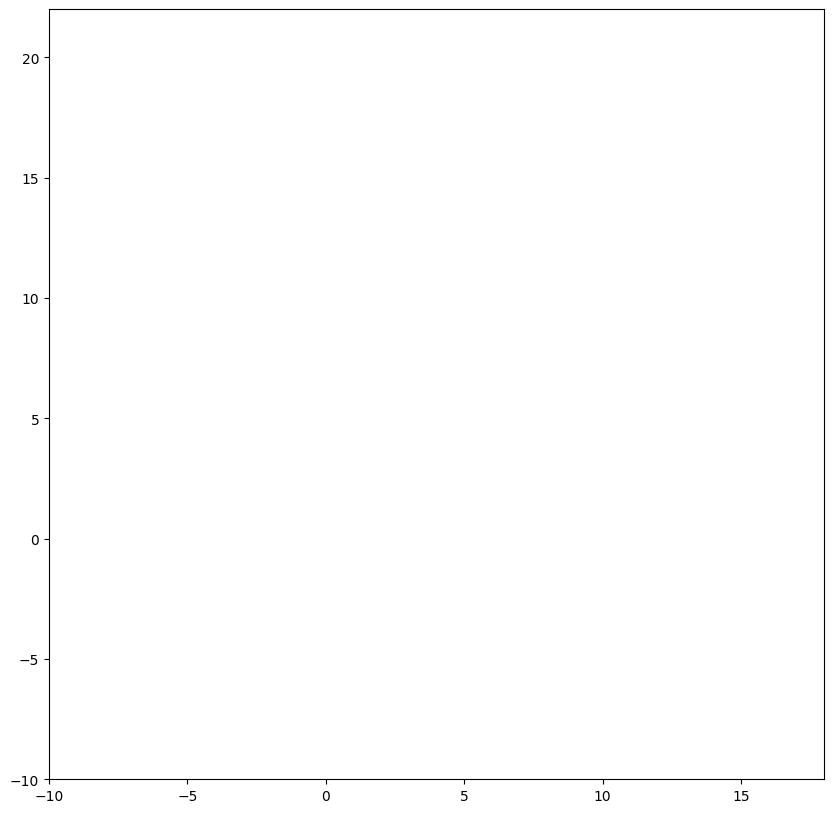

In [5]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os

file=f"{os.path.dirname(input_path)}/{key}.npy"
x=np.load(file,allow_pickle=True)
save=os.path.dirname(file)
c=x[:,0].astype(int)
c=[classes[i] for i in list(c)]
feature=x[:,1:]

# key1=f"{key}_TSNE"
# np.random.seed(11)
# emb = TSNE(n_components=2,init="random",perplexity=10,n_iter=500).fit_transform(feature)
# plt.figure(figsize=(10,10))
# sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,palette="tab10",alpha=1.0)
# plt.title(f"{key1}")
# plt.savefig(f"{save}/{key1}.png",dpi=300)

key2=f"{key}_UMAP"
emb=umap.UMAP(n_neighbors=15,min_dist=0.1,random_state=15).fit_transform(feature)
print(emb.shape)
plt.figure(figsize=(10,10))
plt.xlim(-10,18)
plt.ylim(-10,22)
n=emb.shape[0]

style={}
for t in classes:
    if "zhongkuang" in t:
        style[t]="^"
        continue
    elif "hougaiban" in t:
        style[t]="v"
        continue
    elif "industry" in t:
        style[t]="P"
        continue
    style[t]="o"

sns.scatterplot(x=emb[:,0],y=emb[:,1], hue=c, palette="tab10",alpha=1.0,style=c,markers=style,edgecolor='w')
plt.title(f"{key2}")
plt.savefig(f"{save}/{key2}.png",dpi=300)

# feature抽取 clip

In [11]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:33210"
os.environ["https_proxy"] = "http://127.0.0.1:33210"

from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoFeatureExtractor,CLIPVisionModel
import torchvision.transforms as T
import torch
import random
import numpy as np

from tqdm import tqdm

input_path="D:/yc/data/hix/dm4/consistency"
classes=[t for t in os.listdir(input_path) if os.path.isdir(f"{input_path}/{t}")]

random.seed(12)
images=[]
for c in classes:
    imgs=os.listdir(f"{input_path}/{c}")
    images+=[(f"{input_path}/{c}/{t}",classes.index(c)) for t in imgs]

ckpt = "openai/clip-vit-base-patch16" #"openai/clip-vit-large-patch14"
extractor = AutoFeatureExtractor.from_pretrained(ckpt)
model = CLIPVisionModel.from_pretrained(ckpt)

print(extractor.size)

transform = T.Compose(
    [
        T.Resize( int( (224 / 224) * extractor.size["shortest_edge"] ) ),
        T.CenterCrop(extractor.size["shortest_edge"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

data=[]
for image,c in tqdm(images):
    x = torch.stack([transform(Image.open(image))]).to(model.device)
    x = {"pixel_values":x}
    feature = model(**x).last_hidden_state[:, 0]
    data.append(np.hstack( (np.array([c]),feature.squeeze(0).detach().cpu().numpy())))


data=np.vstack(data)
np.save(f"dm_image_clip_feature.npy",data)
    

d:\yc\transformers\src\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


{'shortest_edge': 224}


100%|██████████| 87/87 [00:12<00:00,  7.03it/s]


# clip tsne

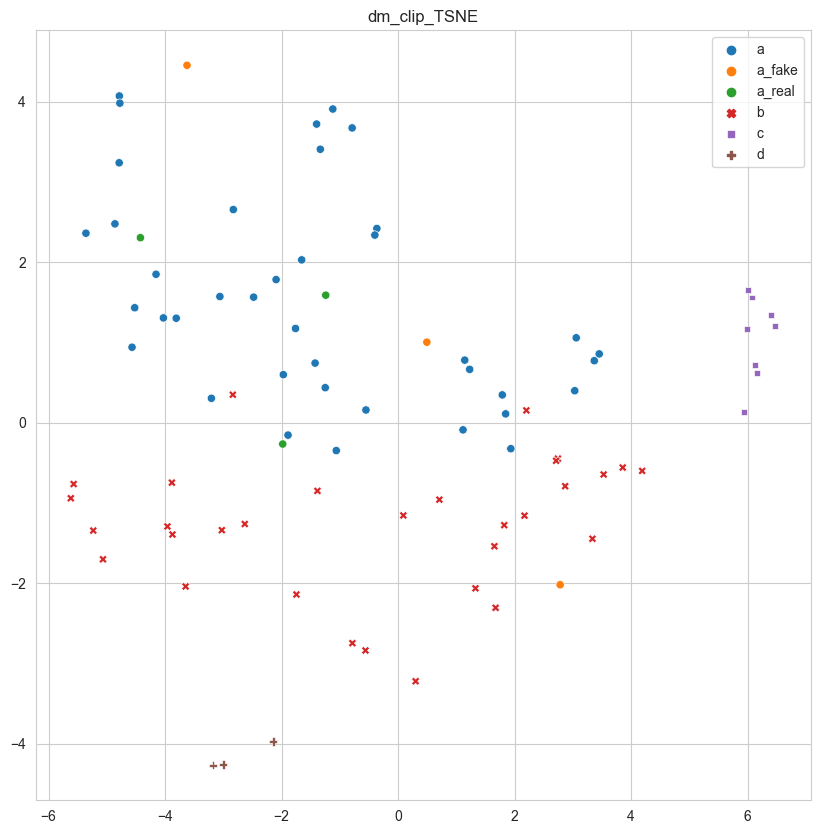

In [12]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

input_path="D:/yc/data/hix/dm4/consistency"
classes=[t for t in os.listdir(input_path) if os.path.isdir(f"{input_path}/{t}")]

x=np.load(f"dm_image_clip_feature.npy",allow_pickle=True)
c=x[:,0].astype(int)
c=[classes[i] for i in list(c)]
feature=x[:,1:]

key="dm_clip"

key1=f"{key}_TSNE"
np.random.seed(11)
emb = TSNE(n_components=2,init="random",perplexity=30,n_iter=500).fit_transform(feature)
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,
                style=[t.split("_")[0] for t in c],
                palette="tab10",alpha=1.0)
plt.title(f"{key1}")
plt.savefig(f"{key1}.png",dpi=300)

# key2=f"{key}_UMAP"
# emb=umap.UMAP(n_neighbors=15,min_dist=0.1,random_state=14).fit_transform(feature)
# print(emb.shape)
# plt.figure(figsize=(10,10))
# sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,
#                 style=[t.split("_")[0] for t in c],
#                 palette="tab10",alpha=1.0)
# plt.title(f"{key2}")
# plt.savefig(f"{key2}.png",dpi=300)

# AE

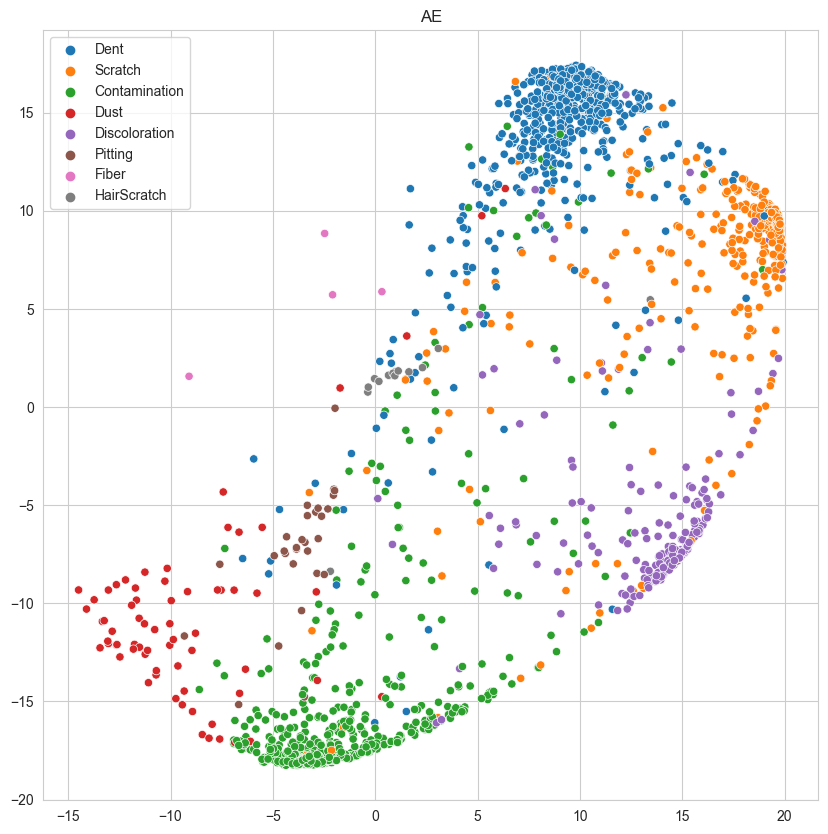

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

classes = ['Contamination', 'Dent', 'Discoloration', 'Dust', 'Fiber', 'HairScratch', 'Pitting', 'Scratch']

x=np.load("feature_ae.npy",allow_pickle=True)
c=x[:,0].astype(int)
k=np.isin(c,[0,1,2,3,4,5,6,7])
c=c[k]
c=[classes[i] for i in list(c)]
emb=x[k,1:]

plt.figure(figsize=(10,10))
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=c,palette="tab10",alpha=1.0)
plt.title("AE")
plt.show()

In [14]:
import torch
import torch.nn.functional as F

input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = F.cosine_similarity(input1, input2)
print(torch.mean(output))

tensor(1.9048)


In [2]:
import torch
import torch.nn.functional as F
from model import *

model=STN2()
x = torch.randn(4,3,256,256)
y=model(x)
print(y.shape)

torch.Size([4, 3, 256, 256])


In [1]:
import torch

x = torch.randn(3,1,256,256)

x=x.repeat(1,3,1,1)
print(x.shape)

torch.Size([3, 3, 256, 256])


In [1]:
import cv2
import numpy as np
from feature import *
import matplotlib.pyplot as plt

feature=FeatureDeep()
x=feature("D:/yc/data/side900_instance/Discoloration/DRD24020GCL1L53AG+0A+XXXXXXXXXXX+K022K04397X_S3-H-A2-2-Btm_1_yi_se._0777.jpg")

print(x.shape)

d:\yc\python\python38\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(1000,)


In [1]:
import torch
from mmpretrain import get_model
model = get_model('D:/yc/mmpretrain/configs/clip/vit-base-p16_pt-64xb64_in1k-384px.py',pretrained='D:/yc/mmpretrain/benchmark/clip-vit-base-p16_laion2b-in12k-pre_3rdparty_in1k-384px_20221220-84ed0cc0.pth')
x = torch.rand((1, 3, 384, 384))
y = model(x)
print(y.shape)

Loads checkpoint by local backend from path: D:/yc/mmpretrain/benchmark/clip-vit-base-p16_laion2b-in12k-pre_3rdparty_in1k-384px_20221220-84ed0cc0.pth
08/10 09:48:22 - mmengine - INFO - Resize the pos_embed shape from torch.Size([1, 577, 768]) to torch.Size([1, 197, 768]).
torch.Size([1, 1000])


In [50]:
import kornia.augmentation as K
import torch
import torch.nn as nn
import cv2
import numpy as np
from kornia.filters import Canny,Sobel

t = lambda x: torch.tensor(x)
p = lambda x: nn.Parameter(t(x))
torch.manual_seed(42)

img=cv2.imread("D:/yc/data/side300/train/000083_S3-H-A2-2-Top_1_225_ZW-.jpg")

x = torch.tensor(img.astype(np.float), requires_grad=False).unsqueeze(0).permute(0,3,1,2)

m = K.ColorJitter(p([0.8,0.8]), p([0.7, 0.7]), p([0.6, 0.6]), t([0.1, 0.1]))

out = m(x)

loss = nn.MSELoss()(out.repeat(1,3,1,1), x)
optimizer_param = torch.optim.SGD(m.parameters(), lr=0.1)
loss.backward()
optimizer_param.step()

print(m.brightness)

C:\Users\yc\AppData\Local\Temp\ipykernel_13872\2592473799.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = torch.tensor(img.astype(np.float), requires_grad=False).unsqueeze(0).permute(0,3,1,2)


TypeError: brightness should be a tensor with length 2 whose values between (0, inf). Got Parameter containing:
tensor([0.8000], requires_grad=True).

In [39]:
import torch

x=torch.tensor([1,1])
print(x)

tensor([1, 1])


# 小物体分类 样本生成

In [ ]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:33210"
os.environ["https_proxy"] = "http://127.0.0.1:33210"

import random
from diffusers import StableDiffusionPipeline
import torch
from tqdm import tqdm

n=128//2
output_path="D:/yc/classify/save/tiny"
generator = torch.Generator(device="cuda")
postive_prompt = "an extremely tiny dot on the fine industrial product gray background"
negtive_prompt = "fine industrial product gray background"

pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",torch_dtype=torch.float16,)
pipeline.to("cuda")

os.makedirs(f"{output_path}/defect",exist_ok=True)
random.seed(42)
for _ in tqdm(range(n)):
    seed=random.randint(0,99999999)
    generator = generator.manual_seed(seed)
    image = pipeline(postive_prompt,generator=generator, width=512, height=512, guidance_scale=12.0).images[0]
    
    image.save(f"{output_path}/defect/{seed}.jpg",quality=100)
    
os.makedirs(f"{output_path}/bg",exist_ok=True)
random.seed(31)
for _ in tqdm(range(n)):
    seed=random.randint(0,99999999)
    generator = generator.manual_seed(seed)
    image = pipeline(negtive_prompt,generator=generator, width=512, height=512, guidance_scale=12.0).images[0]
    
    image.save(f"{output_path}/bg/{seed}.jpg",quality=100)

# crop by labelme

In [29]:
import os,json,re
import numpy as np
import cv2

def crop_anno(input_path,output_path,anno_files):
    j=0
    for i,s in enumerate(anno_files):
        t=json.load(open(s,"r"))
        
        image=cv2.imread(f"{input_path}/{t['imagePath']}")
        h,w,_=image.shape

        annos=t["shapes"]
        for anno in annos:
            c=anno["label"]
            coord=np.array(anno["points"])

            xymin=np.min(coord,axis=0)
            xymax=np.max(coord,axis=0)
            center=(xymax+xymin)/2.0
            wh=(xymax-xymin)*bleed/2.0
            xymin = center - wh
            xymax = center + wh
            # avoid violation
            xymin=np.maximum(xymin,np.array([0,0]))
            xymax=np.minimum(xymax,np.array([w,h]))
            
            xy=np.vstack((xymin,xymax)).T.astype(int)
            
            crop=image[xy[1][0]:xy[1][1],xy[0][0]:xy[0][1],:]
            
            j+=1
            name=re.sub(".json",f"_{c}_{j}.jpg",os.path.basename(s))
            
            output_path_=f"{output_path}/{c}"
            if not os.path.exists(output_path_):
                os.makedirs(output_path_,exist_ok=False)
            cv2.imwrite(f"{output_path_}/{name}",crop)

input_path="D:/yc/data/side_hole/labelme"
output_path="D:/yc/data/side_hole/instance"
bleed=np.array([1.2,1.2])

os.makedirs(output_path,exist_ok=True)
anno_files=[f"{input_path}/{t}" for t in os.listdir(input_path) if ".json" in t]
crop_anno(input_path=input_path,output_path=output_path,anno_files=anno_files)

# 手动划分

In [3]:
import os,shutil,random

input_path=r"D:\yc\data\ins\hix"

classes=os.listdir(input_path)

train=f"{input_path}_train"
test=f"{input_path}_test"

frac=0.5

os.makedirs(train,exist_ok=True)
os.makedirs(test,exist_ok=True)

for c in classes:
    files=os.listdir(f"{input_path}/{c}")
    n=len(files)
    n_train=int(n*frac)
    train_file=random.sample(files,n_train)
    test_file=[t for t in files if t not in train_file]
    
    os.makedirs(f"{train}/{c}",exist_ok=True)
    for t in train_file:
        shutil.copy(f"{input_path}/{c}/{t}",f"{train}/{c}/{t}")
        
    os.makedirs(f"{test}/{c}",exist_ok=True)
    for t in test_file:
        shutil.copy(f"{input_path}/{c}/{t}",f"{test}/{c}/{t}")